# 0x01 Density Estimation

Density estimation refers to the task of modelling $p(x)$， given the observations $x_1, x_2, \ldots, x_n$.

Of course, this is an ill-posed problem, since we can always model a function, described as
$$p(x) = \sum_{i=1}^n \delta(x - x_i)$$
where $\delta$ is the Dirac delta function:
$$\delta(x) = \begin{cases} 0 & x \neq 0 \\ +\infty & x = 0 \end{cases}$$

This is a valid density, but it is not very useful. 
In fact, any $p(x)$ that is nonzero at $x_i$ is a valid density for the observations.
We need to add more constraints or assumptions to the model.

In this hands-on, we will experiment with two approaches to density estimation:
1. **Parametric density estimation**: We assume a specific form for the density function, and we estimate the parameters of that function from the data.
2. **Non-parametric density estimation**: We do not assume a specific form for the density function, but we use the data to estimate it directly.

## 1. Dataset

We will start our tutorial using the simple yet classic dataset of the **Iris** flower.

The dataset contains 150 samples of iris flowers, with 4 features (sepal length, sepal width, petal length, and petal width) and 3 classes (Setosa, Versicolor, and Virginica),
which is presented in the R.A. Fisher's 1936 paper "The use of multiple measurements in taxonomic problems".

> 💻 **LIBRARY**
> 
> We will be using the `pandas` library,
>
> which is a powerful data analysis and manipulation library for Python (especially for tabular data).
>
> You can do along with the code below. But, if you are not comfortable with pandas, you can first check out the official tutorials:
> - [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html).
> - [Getting started with pandas](https://pandas.pydata.org/docs/getting_started/intro_tutorials/).

In [1]:
import pandas as pd

# Import data from the csv file
iris_df = pd.read_csv("data/Iris.csv")

# Display the first few rows of the data
iris_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


## 2. Parametric Density Estimation

Parametric density estimation assumes a specific form for the density function, and estimates the parameters of that function from the data.

Before you do the estimation, you have to make an assumption about the form of the density function.

Let us start by looking at `PetalLengthCm`, assuming that our data is **normally distributed**, i.e. it satisfies the following density function:

$$p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of the data.

We then try to estimate the parameters $\mu$ and $\sigma$ from the data.

> 💻 **LIBRARY**
>
> [Scipy](https://scipy.org/) is a library dedicated to scientific computing,
>
> and has a wide range of functions for probability / statistics, signal processing, optimization, etc.
>
> We will use it to estimate the parameters of the normal distribution.

In [2]:
from scipy import stats

# Fit the normal distribution to the data
petal_length = iris_df["PetalLengthCm"]
mu, std = stats.norm.fit(petal_length)
print(f"mu: {mu}, std: {std}")

mu: 3.758666666666666, std: 1.7585291834055212


Now we have the $\mu$, $\sigma$ of the data.

Let's plot the data and the estimated density function we have derived.

> 💻 **LIBRARY**
>
> We will use the `matplotlib` library to plot the data and the estimated density function.
>
> Matplotlib is a plotting library for Python and provides a MATLAB-like interface.
> 
> For Python, the most common use is the `pyplot` module, which provides a MATLAB-like interface.

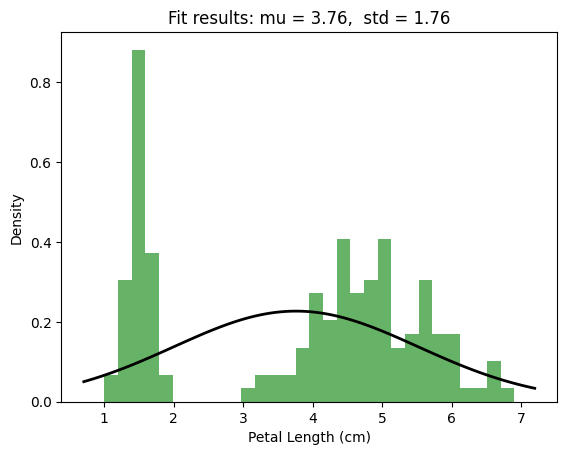

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot the histogram of the data
plt.hist(petal_length, bins=30, density=True, alpha=0.6, color="g")
# Get the current x-axis range
xmin, xmax = plt.xlim()
# Generate a linear space from xmin to xmax, with 100 points
x = np.linspace(xmin, xmax, 100)
# Calculate the PDF of the normal distribution
p = stats.norm.pdf(x, mu, std)
# Plot the PDF
plt.plot(x, p, "k", linewidth=2)
title = f"Fit results: mu = {mu:.2f},  std = {std:.2f}"
plt.title(title)
plt.xlabel("Petal Length (cm)")
plt.ylabel("Density")
plt.show()

> 🤔 **THINKING**
>
> - Does our approach provide a good fit for the data? Why?
> - Hence, what is a possible limitation of the parametric density estimation?
> - What can we do to improve our assumption process?

Testing is a way to validate our assumption about our distribution.

Although a sophisticated domain in probability and statistics,
various tests can help us to validate our assumption before we fit the model.

For the petal length, let's run a **Shapiro-wilk test**. It is a test to reveal how confident we are about our assumption of normality.

In [4]:
# Perform the Shapiro-Wilk test for normality
stat, p_shapiro = stats.shapiro(petal_length)

print(f"Statistics={stat}, p-value={p_shapiro}")

Statistics=0.8764246351886722, p-value=7.545419569615808e-10


`p_shapiro` is the **p-value** of the test.

In a loose manner, **p-value** means the probability of observing the data given the **null hypothesis** (which is _"the hypothesis we would like to reject"_) is true.

For Shapiro-wilk test, the **null hypothesis** is that the data is normally distributed.

So, we say that, the probability of the data being normally distributed is at the scale of $10^{-10}$.
This is a very low probability, so we can confidently say that the data is **NOT** normally distributed.

> 📚 **EXERCISE**
>
> How about the sepal width (`SepalWidthCm`)? Does it fit nicely into a normal distribution?
>
> Try work out your own analysis!

In [5]:
# === Your code here ===

## 3. Non-parametric Density Estimation

We have discovered that we have to do some assumptions about the data distribution before we can estimate the density function in the parametric approach.

Can we do something without making any assumptions about the type of distribution?

We can! In this tutorial, we will try out two non-parametric methods:
1. Kernel Density Estimation (KDE)
2. K-nearest neighbors (KNN)

### 3.1 Kernel Density Estimation (KDE)

Let's start with the Parzen window method, one of the simplest form of KDE.

The rationale is: the density at a point is estimated by the number of data points in a small neighborhood around that point.

Let's try to estimate the density of the `PetalLengthCm` using the Parzen window method.

In [6]:
from sklearn import neighbors

In [7]:
# Tophat is equivalent to the hypercube.

kde = neighbors.KernelDensity(bandwidth=0.5, kernel="tophat")

# Convert the data to a 2D array, since KDE in sklearn requires a 2D array
petal_length_2d = petal_length.values.reshape(-1, 1)
# Run our data through the KDE
kde.fit(petal_length_2d)

KernelDensity(bandwidth=0.5, kernel='tophat')

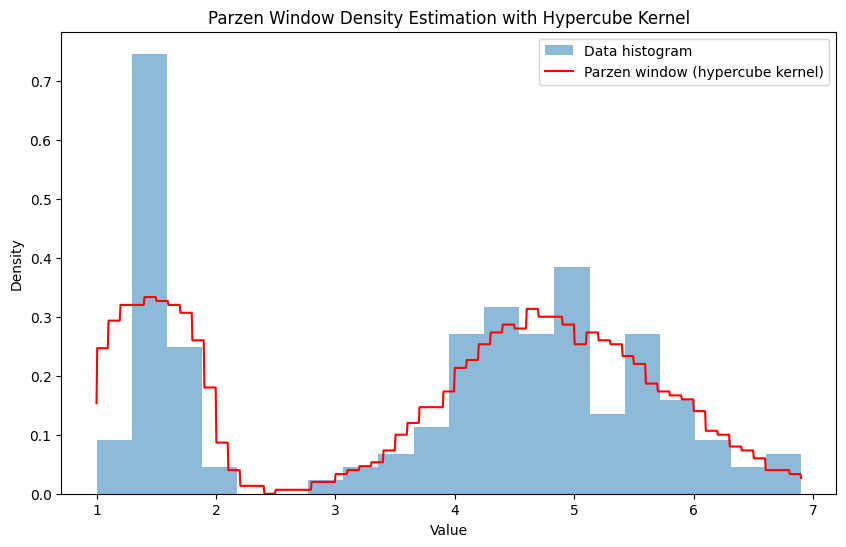

In [8]:
# Evaluate the density on a grid
x_grid = np.linspace(petal_length_2d.min(), petal_length_2d.max(), 1000).reshape(-1, 1)
log_density = kde.score_samples(x_grid)
density = np.exp(log_density)

# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(petal_length, bins=20, density=True, alpha=0.5, label="Data histogram")
plt.plot(x_grid, density, "r-", label="Parzen window (hypercube kernel)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Parzen Window Density Estimation with Hypercube Kernel")
plt.legend()
plt.show()

We can observe that the KDE method reflects the distribution better
comparing to our original parametric normal distribution assumption.

Specifically, it reflects the multimodal nature of the data.

One of the key hyperparameters in KDE is the **bandwidth**.

Remember we have talked about the "neighborhood" in the Parzen window method?
Bandwidth is the parameter that controls the size of the neighborhood.

How about we run another KDE with a different bandwidth?

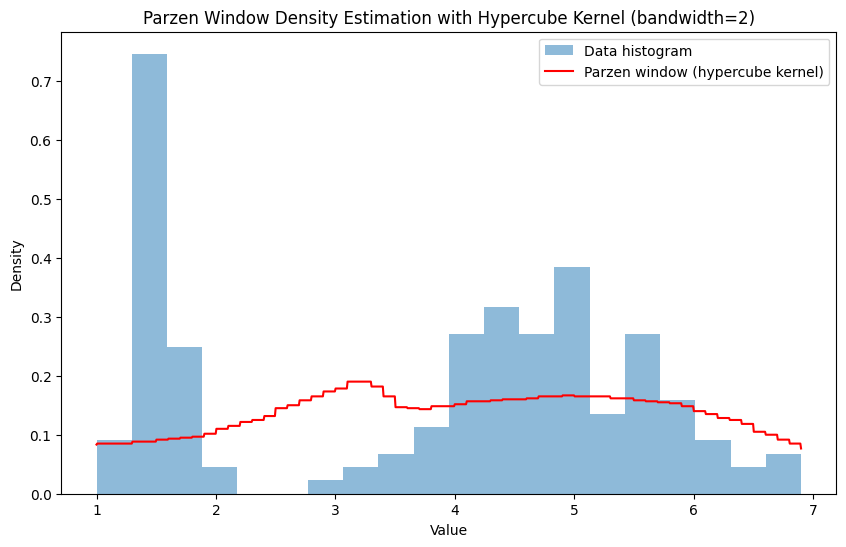

In [9]:
kde_bw2 = neighbors.KernelDensity(
    bandwidth=2, kernel="tophat"
)  # changed bandwidth from 0.5 to 2
kde_bw2.fit(petal_length_2d)

# Plot the result
log_density_bw2 = kde_bw2.score_samples(x_grid)
density_bw2 = np.exp(log_density_bw2)

plt.figure(figsize=(10, 6))
plt.hist(petal_length, bins=20, density=True, alpha=0.5, label="Data histogram")
plt.plot(x_grid, density_bw2, "r-", label="Parzen window (hypercube kernel)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.title("Parzen Window Density Estimation with Hypercube Kernel (bandwidth=2)")
plt.legend()
plt.show()

> 🤔 **THINKING**
>
> - What did you observe when we change the bandwidth? Do you think it is a good bandwidth?
> - What is the effect of the bandwidth on the KDE estimation?

> 📚 **EXERCISE**
>
> 1. Tweak the bandwidth parameter and observe the effect on the KDE estimation.
> 2. Besides the top-hat (i.e. hypercube kernel), there are other kernels that can be used in KDE. One of them is the Gaussian kernel.
>    Try to implement the Gaussian kernel and see how it behaves. 
> Gaussian kernel can be used by changing the `kernel` parameter in the `KernelDensity` function.

In [10]:
# === Your code here ===

### 3.2 K-nearest neighbors (KNN)

K-nearest neighbors (KNN) is another non-parametric method for density estimation.

It takes a different approach by asking: For me to have k points as my neighbors, how big should my neighborhood be?

Let's implement one from scratch.

In [11]:
# We will reuse the `petal_length_2d` variable from the previous cell
# Set hyperparameter K
K = 30
knn = neighbors.NearestNeighbors(n_neighbors=K)
knn.fit(petal_length_2d)

NearestNeighbors(n_neighbors=30)

In [12]:
# Get the points we would like to estimate the density for
xmin, xmax = petal_length_2d.min(), petal_length_2d.max()
x_linspace = np.linspace(xmin, xmax, 1000).reshape(-1, 1)

In [13]:
# How about we see the output of the kneighbors method?
distances, indices = knn.kneighbors(x_linspace)

print(f"Distances shape: {distances.shape}")
print(f"Indices shape: {indices.shape}")

Distances shape: (1000, 30)
Indices shape: (1000, 30)


Good! So we see that the first axis of `distances` represents the point, while the second axis represents the distance to the k-th nearest neighbor.

We can then slice out the furthest distance to get the **half** neighborhood size for each point we would like to estimate the density.

In [ ]:
furthest_distance = distances[:, -1]
print(furthest_distance.shape)

(1000,)

In [ ]:
# Now let's calculate the neighborhood density!

# Remember we are calculating the radius for the furthest distance, so we need to multiply by 2 to get the "diameter"
volume = 2 * furthest_distance

# Calculate the density
density = K / (volume * len(petal_length_2d))

print(density.shape)

(1000,)

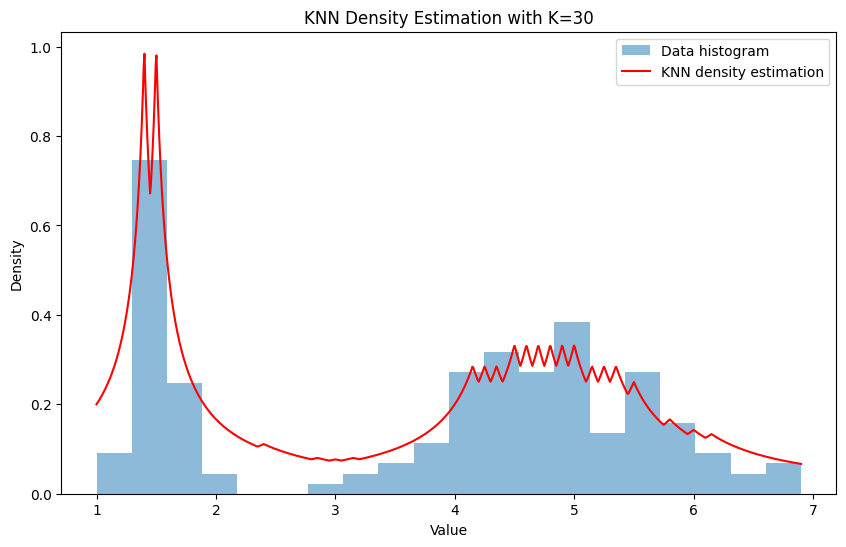

In [16]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.hist(petal_length, bins=20, density=True, alpha=0.5, label="Data histogram")

plt.plot(x_linspace, density, "r-", label="KNN density estimation")
plt.xlabel("Value")
plt.ylabel("Density")

plt.title(f"KNN Density Estimation with K={K}")
plt.legend()
plt.show()

> 🤔 **THINKING**
>
> - Try to make K = 10. Then K = 2. What do you observe? How about K = 50?
> - What is the effect of K on the KNN estimation?